In [618]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import shutil

# Example of directly accessing S3 from notebook (did not scale well for extracting files)

In [3]:
# Example for opening a bucket as a filesystem and viewing the contents
if False:
    import s3fs # for attaching S3 bucket to notebook
    fs = s3fs.S3FileSystem(anon=False, key='<key>', secret='<secret>')
    fs.ls('s3://bucket/path/')

In [4]:
# Example code for loading data from S3 into the notebook
if False:
    bucket='my-bucket'
    data_key = 'train.csv'
    data_location = 's3://{}/{}'.format(bucket, data_key)
    pd.read_csv(data_location)

In [5]:
# Example for opening a file for read
if False:
    img_file = fs.open('s3://descriptiveworld-datasets/DeepFashion1/Img/img.zip', 'rb')

# Copy files from S3 bucket to notebook EC2 instance

In [57]:
# run only the first time the instance is created and launched
#!mkdir ../../../DeepFashion1
#!cd ../../../DeepFashion1

In [ ]:
# setup aws CLI with personal credentials
# this command may be easier to run from a terminal session instead of notebook
#!aws configure

In [ ]:
# copy the DF1 bucket from S3 to this instance
#!aws s3 cp s3://descriptiveworld-datasets/DeepFashion1/ . --recursive

In [619]:
!ls ../../../DeepFashion1

Anno_coarse  Anno_fine	Eval  fashion  fashion.zip  Img  README.txt  temp


# Inspect full image archive without extracting all files

In [620]:
pre_path = '../../../DeepFashion1/'

In [621]:
zipf = zipfile.ZipFile(pre_path+'Img/img.zip') # not using high-res images to simplify data wrangling

In [622]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'product_name', 'filename'])
df['path'] = filenames

In [623]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=10)

289229


,index,root_path,product_name,filename,path
223498,227880,img,Scuba_Knit_Pencil_Skirt,img_00000009.jpg,img/Scuba_Knit_Pencil_Skirt/img_00000009.jpg
236830,241496,img,Southwestern_Print_Racerback_Tank,img_00000034.jpg,img/Southwestern_Print_Racerback_Tank/img_0000...
42634,43437,img,Chandelier_Print_Tee,img_00000032.jpg,img/Chandelier_Print_Tee/img_00000032.jpg
200931,204878,img,Pintucked_Pleat-Hem_Blouse,img_00000015.jpg,img/Pintucked_Pleat-Hem_Blouse/img_00000015.jpg
257891,262941,img,Terry_Keyhole_Back_Dress,img_00000044.jpg,img/Terry_Keyhole_Back_Dress/img_00000044.jpg
190086,193785,img,Open-Front_Collared_Jacket,img_00000017.jpg,img/Open-Front_Collared_Jacket/img_00000017.jpg
77013,78465,img,Cuffed_Denim_Cutoffs,img_00000052.jpg,img/Cuffed_Denim_Cutoffs/img_00000052.jpg
32042,32670,img,Boxy_Woven_Moto_Jacket,img_00000047.jpg,img/Boxy_Woven_Moto_Jacket/img_00000047.jpg
176618,180026,img,Meander_Pattern_Sweater,img_00000017.jpg,img/Meander_Pattern_Sweater/img_00000017.jpg
152542,155406,img,Keith_Haring_Heart_Print_Tee,img_00000009.jpg,img/Keith_Haring_Heart_Print_Tee/img_00000009.jpg


In [15]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 2.74 GB


# Basic EDA

### Number of product types (each image file is a unique product)

In [632]:
# Number of unique products
products = np.unique(df.product_name)
len(products)

5621

In [633]:
def flattenTypes(val):
    lst = val.split('_')
    return lst[-1]

In [634]:
df['product_type'] = df.product_name.apply(flattenTypes)
all_cats = np.unique(df.product_type)
print(len(all_cats))
all_cats

46


array(['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan',
       'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes',
       'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley',
       'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs',
       'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie',
       'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts',
       'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee',
       'Top', 'Trunks', 'Turtleneck'], dtype=object)

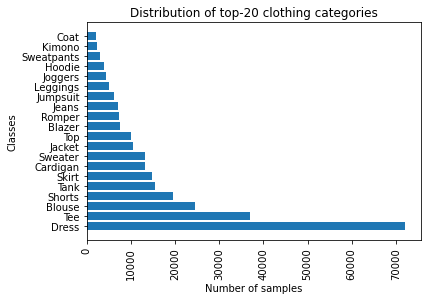

In [635]:
histdata = df.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [636]:
histdata[histdata['root_path'] > 1000]['index']

product_type
Dress          72158
Tee            36887
Blouse         24562
Shorts         19666
Tank           15429
Skirt          14773
Cardigan       13311
Sweater        13123
Jacket         10467
Top            10078
Blazer          7497
Romper          7408
Jeans           7076
Jumpsuit        6153
Leggings        5013
Joggers         4416
Hoodie          4048
Sweatpants      3048
Kimono          2294
Coat            2120
Cutoffs         1669
Sweatshorts     1106
Name: index, dtype: int64

### Load the bounding box data and merge with the file list

In [637]:
# read in the bounding box dataset for all records
f = open(pre_path+'/Anno_coarse/list_bbox.txt', 'rt')
boxes = f.readlines()
boxes = boxes[2:]
boxes = [x.replace('\n', '') for x in boxes]
#boxes = [x.replace('img/', 'img_highres/') for x in boxes]
boxes = [' '.join(x.split()).split() for x in boxes]
df_boxes = pd.DataFrame(boxes, columns=['path', 'x1', 'y1', 'x2', 'y2'])
df_boxes.head()

,path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262


In [638]:
df_all = df.merge(df_boxes, on='path')
df_all.sample(5)

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2
27548,28077,img,Boxy_Cable_Knit_Sweater,img_00000012.jpg,img/Boxy_Cable_Knit_Sweater/img_00000012.jpg,Sweater,041,045,175,232
131607,134039,img,French_Terry_Hoodie,img_00000064.jpg,img/French_Terry_Hoodie/img_00000064.jpg,Hoodie,014,063,163,226
157523,160493,img,Lace-Paneled_Tank,img_00000026.jpg,img/Lace-Paneled_Tank/img_00000026.jpg,Tank,039,018,161,300
6145,6287,img,Abstract_Print_Maxi_Dress,img_00000009.jpg,img/Abstract_Print_Maxi_Dress/img_00000009.jpg,Dress,115,001,179,184
206336,210379,img,Plunging_V-Neckline_Dress,img_00000076.jpg,img/Plunging_V-Neckline_Dress/img_00000076.jpg,Dress,058,033,167,300


### Inspect a few sample images and corresponding bounding boxes

In [639]:
toplot = df_all[df_all.product_name=='Scalloped_Halter_Dress'][:10]

In [640]:
# extract sample images from archive to disk
filelist = toplot.path.values
zipf.extractall(path=pre_path+'temp/', members=filelist)

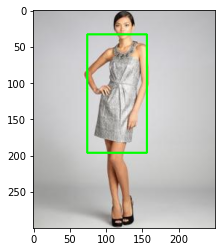

In [641]:
row = toplot.iloc[8].values
img = cv2.imread(pre_path+'temp/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(x1, y1, x2, y2) = [int(x) for x in row[-4:]]
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

# Down-select data based on YOLOv5 recommendations for training

Per YOLOv5 training guidelines (https://docs.ultralytics.com/tutorials/training-tips-best-results/), there should be minimum:

- 1.5k images per class (i.e. different blouse samples)
- 10k instances per class (i.e. all blouse samples, including data augmentations)
- 0-10% background images (images with no objects) to help reduce FPs


Based on various searches, assume augmentation increases instance count by 10x.

Use 1.5k as minimum threshold for class.

In DF1, each sample is a unique item.

Augmentation will result in 10 instances for each item.

This will meet the requirement for 10k instances per class.


Risk:

- are 10 instances per item sufficient within a class
- are the items within a class adequately similar?


In [642]:
histdata[histdata['root_path'] > 1500]['index']

product_type
Dress         72158
Tee           36887
Blouse        24562
Shorts        19666
Tank          15429
Skirt         14773
Cardigan      13311
Sweater       13123
Jacket        10467
Top           10078
Blazer         7497
Romper         7408
Jeans          7076
Jumpsuit       6153
Leggings       5013
Joggers        4416
Hoodie         4048
Sweatpants     3048
Kimono         2294
Coat           2120
Cutoffs        1669
Name: index, dtype: int64

## Additional considerations

### Similarity
Some items will be difficult to distinguish because of design similarity, they have essentially the same function (bottom or top garment).
- Jeans, Joggers, Sweatpants
- Blouse, Sweater, Cardigan, Hoodie

These items are typically of different fabric/texture as well, so are easy to discern by touch.

The similarities of items within these classes offer an opportunity to merge the classes to increase the samples per class.  For example:
- Long_Leg:  Jeans + Joggers + Sweatpants
- Long_Sleeve:  Blouse + Sweater + Cardigan + Hoodie


### Ubiquity

Prior experiments with training YOLOv5 to identify Tees, Blouses, Pants, Shorts and using the model to identify real clothing suggest that Short are easily confused with real-world objects (carpet, bed, pillow, dresser, t-shirt, etc.).  Given that this class of garment is easily discernable to users (via self-organization of wardrobe or by touch/weight), we may consider removing the classes Shorts and Cutoffs from the training data.


### Exclusions

- Leggings
    - typically stored in drawer
    - not serving same purpose as other long-leg garments
- Coat/Blazer/Jacket 
    - easily discerned by touch / self-organization
    - less numerous in personal wardrobe
- Jumpsuit / Romper: for later release?
- Kimono not in immediate target user community

Anything with less than 1,500 samples is excluded.


### Classes for further consideration

In [643]:
# merge similar classes 
# - Long_Leg:  Jeans + Joggers + Sweatpants
# - Long_Sleeve:  Blouse + Sweater + Cardigan + Hoodie

df_all['product_type'] = df_all.product_type.apply(lambda x: 'Long_Leg' if x in ['Jeans', 'Joggers', 'Sweatpants'] else x)
df_all['product_type'] = df_all.product_type.apply(lambda x: 'Long_Sleeve' if x in ['Blouse', 'Sweater', 'Cardigan', 'Hoodie'] else x)

In [644]:
# exclusions
excl = histdata[histdata['root_path'] < 1500]['index'].index.values
excl = np.append(excl, ['Coat', 'Shorts', 'Cutoffs', 'Top', 'Skirt','Blazer', 'Jacket', 'Leggings', 'Jumpsuit', 'Romper', 'Kimono'])
df_all = df_all[df_all.product_type.apply(lambda x: x not in excl)]

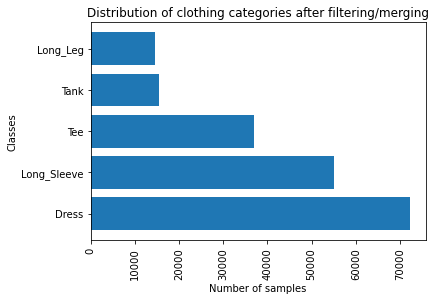

In [645]:
histdata = df_all.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of clothing categories after filtering/merging')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [646]:
cats = np.unique(df_all.product_type)
cats

array(['Dress', 'Long_Leg', 'Long_Sleeve', 'Tank', 'Tee'], dtype=object)

# Prepare subset of overall data based on specific categories of products

### Sample files in categories

In [647]:
subset = df_all #[df_all.product_type.isin(cats)] # filter no longer needed after code change

In [648]:
# numitems is used to determine the category with the smallest number of items
numitems = min(subset.groupby('product_type').count().path)
numitems

14540

In [649]:
# then we sample numitems * 90% in each of the cateogries to leave images for later validation and/or testing
subsample = subset.groupby('product_type').sample(n=int(numitems*.9))
len(subsample)

65430

<span style='color:red'>WARNING vvvvvvv</span>

In [652]:
# WARNING THIS WILL DELETE THE previously created output of this notebook
!rm -r ../../../DeepFashion1/fashion
!rm ../../../DeepFashion1/fashion.zip

<span style='color:red'>WARNING ^^^^^^^</span>

In [653]:
%%time
# Extract all the sample files from the zipped archive to disk
filelist = subsample.path.values
zipf.extractall(path=pre_path+'fashion/', members=filelist)

CPU times: user 12.9 s, sys: 4.09 s, total: 17 s
Wall time: 1min 11s


In [654]:
# check number of files extracted
!find ../../../DeepFashion1/fashion -type f | wc -l

65430


### Determine dimensions and remove samples not meeting criteria

In [655]:
%%time
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
for file in filelist[:]:
    i = Image.open(pre_path+'fashion/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

CPU times: user 7.52 s, sys: 1.39 s, total: 8.91 s
Wall time: 23.5 s


In [656]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

       i_h
i_w       
300  17566
       i_w
i_h       
300  49596


In [657]:
most_common_dim = 300

In [658]:
subsample = pd.concat([subsample.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [659]:
# determine which images are outside the range of the 
toobig = subsample[(subsample['i_w'] > most_common_dim) | (subsample['i_h'] > most_common_dim)]
toosmall = subsample[(subsample['i_w'] < most_common_dim) & (subsample['i_h'] < most_common_dim)]
print(len(toobig), len(toosmall))

4338 8052


In [660]:
toobig.groupby('product_type').count()['path'] + toosmall.groupby('product_type').count()['path']

product_type
Dress          1748
Long_Leg       2409
Long_Sleeve    2617
Tank           2885
Tee            2731
Name: path, dtype: int64

In [661]:
subsample = subsample[~subsample.path.isin(toobig.path)]
subsample = subsample[~subsample.path.isin(toosmall.path)]
len(subsample)

53040

In [662]:
# is it still balanced across classes?
subsample.groupby('product_type').count()['path']

product_type
Dress          11338
Long_Leg       10677
Long_Sleeve    10469
Tank           10201
Tee            10355
Name: path, dtype: int64

In [663]:
# remove images from disk that are not within required size (300px on one or more dimensions)
for file in toobig.path.values:
    os.remove(pre_path+'fashion/'+file)
    
for file in toosmall.path.values:
    os.remove(pre_path+'fashion/'+file)

# Cleanse remaining samples

### Remove images with text inside BBox

<span style='color:red'>NOTE:  Section on OCR is not working due to issue installing tesseract</span>

##### Install Tesseract OCR

In [146]:
#!sudo yum -y update
#!sudo yum --enablerepo=epel --disablerepo=amzn-main install libwebp
#!sudo yum -y install tesseract
#!pip install pytesseract -q

In [ ]:
if False:
    import pytesseract

    def optical_character_recognition(file):
        """ Simple OCR of text from images.

        Parameters
        ----------
        file: Path or str
        Image to examine.
        path: bool
        Indicates whether the file passed in is a path to a file, or an already opened Pillow Image.

        Returns:
        ----------
        str
        Text that was detected.
        """

        # Use Pillow's Image class to open the image
        img = Image.open(file)
        new_size = tuple(2*x for x in img.size)
        img = img.resize(new_size, Image.ANTIALIAS)
        img = img.convert('L')
        text = pytesseract.image_to_string(img, lang='eng', config='-c tessedit_char_whitelist=01234567890ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz --psm 3 --oem 3')
        # Remove '\n\x0c' whiich is found in every image
        text = text[:-3]

if False:
    for i, item in subsample.iterrows():
        fl = pre_path+'fashion/'+item.path
        txt = optical_character_recognition(fl)
        print(txt)

### Identify images with poor BBox definitions

Poor bounding box definition:
- box includes too much blank space compared to the target object, for example the box boundaries are not tight around the object
- box includes too much skin tone compared to the target object, for example the arms are folded an occlude too much of the image

In [664]:
#!pip install fast_colorthief

Note: you may need to restart the kernel to use updated packages.


In [665]:
import fast_colorthief
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

In [672]:
def excessBlankSpace(file, bbox, sensitivity=5):
    # inspired by: https://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv
    #         and: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    # sensitivity is used to give a range of color space to filter for the background color
    img = cv2.imread(file)
    
    frm = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    
    """
        identify area covered by predominant background color within bounding box
    """
    # predominant color
    rgba = cv2.cvtColor(frm, cv2.COLOR_BGR2RGBA)
    crop_rgb = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
    pal = fast_colorthief.get_palette(rgba)
    dominant_color = pal[0]
    
    # area covered by predominant color (maskBgnd)
    lower = np.array(dominant_color)-sensitivity
    upper = np.array(dominant_color)+sensitivity
    maskBgnd = cv2.inRange(crop_rgb, lower, upper)

    # res is calculated to combine with skin masking for visual verification if desired
    maskBgnd_inv = cv2.bitwise_not(maskBgnd)
    bgnd = cv2.bitwise_and(frm, frm, mask=maskBgnd_inv)

    """
        identify area covered by skin tones within bounding box
    """
    hsv = cv2.cvtColor(bgnd, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80]) # found on the internet (one of many)
    upper = np.array([20, 255, 255]) # found on the internet (one of many)
    maskSkin = cv2.inRange(hsv, lower, upper)
    
    # out is calculated and returned for visual verification if desired
    maskSkin_inv = cv2.bitwise_not(maskSkin)    
    out = cv2.bitwise_and(bgnd,bgnd, mask= maskSkin_inv)
    
    #
    # output
    #
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    
    return img, crop_rgb, maskBgnd, maskSkin, out

In [673]:
def plotImg(img, crp, msk, res, bbox):
    fig, ax = plt.subplots(1,4)
    
    # add bbox markup
    (x1, y1, x2, y2) = [int(x) for x in bbox]
    img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    ax[0].imshow(img_bbox)
    ax[1].imshow(crp)
    ax[2].imshow(msk)
    ax[3].imshow(res)
    
    plt.show()

In [ ]:
%%time
outsized_bbox_list = []
cnt=0
for i, item in subsample.iterrows():
    if cnt%1000==0: # because tqdm is not working :(
        #print(cnt, len(outsized_bbox_list))
        pass
    file = pre_path+'fashion/'+item.path
    bbox = np.array(item[-6:-2], np.int)
    img, crp, msk1, msk2, res = excessBlankSpace(file, bbox, sensitivity=30)

    # calculate % of bbox occupied by non-desirable 
    # features (predominant background color or skin)
    box_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    msk1_size = msk1[msk1==255].shape
    msk2_size = msk2[msk2==255].shape
    bad_content = max(msk1_size, msk2_size)
    content_ratio = np.round(bad_content[0]/box_size, 2)

    if content_ratio > .8:
        #plotImg(img, crp, msk1, res, bbox) # useful for testing on small sample
        #print(box_size, bad_content[0], bad_ratio) # useful for testing on small sample
        outsized_bbox_list.append(item.path)

    cnt+=1

In [684]:
print('% of images with poor bbox-ing =', round(len(outsized_bbox_list) / len(subsample), 3)*100)

% of images with poor bbox-ing = 1.6


In [685]:
outsized_bbox_list[:5]

['img/Paisley_Cami_Maxi_Dress/img_00000011.jpg',
 'img/Sleeveless_Quilted_Skater_Dress/img_00000043.jpg',
 'img/Floral_Cami_Maxi_Dress/img_00000018.jpg',
 'img/Crisscross_Back_Swiss_Dot_Dress/img_00000016.jpg',
 'img/Crochet-Trimmed_Chiffon_Dress/img_00000002.jpg']

### Identify invalid filenames (those with . in pathname)

In [719]:
to_remove = outsized_bbox_list
for x in subsample.path.values[:]:
    tmp = x.split('.')
    if len(tmp) > 2:
        to_remove.append(x)
to_remove = set(to_remove)

In [720]:
len(to_remove)

1018

### Remove images from files and data

In [686]:
subsample = subsample[~subsample.path.isin(to_remove)]
for file in to_remove:
    os.remove(pre_path+'fashion/'+file)
len(subsample) 

52181

In [687]:
# verify counts are same
!find ../../../DeepFashion1/fashion -type f | wc -l

52181


# Create YOLOv5 training data files and formats

### Prepare additional fields for YOLOv5 label data format

In [688]:
# calculate the elements needed for the YOLOv5 PyTorch training input labels/
subsample.x1 = subsample.x1.astype(int)
subsample.y1 = subsample.y1.astype(int)
subsample.x2 = subsample.x2.astype(int)
subsample.y2 = subsample.y2.astype(int)
subsample.i_w = subsample.i_w.astype(int)
subsample.i_h = subsample.i_h.astype(int)

subsample['x'] = subsample.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
subsample['y'] = subsample.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
subsample['w'] = subsample.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
subsample['h'] = subsample.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
subsample.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h,x,y,w,h
0,189532,img,Must-Have_Scuba_Skater_Dress,img_00000039.jpg,img/Must-Have_Scuba_Skater_Dress/img_00000039.jpg,Dress,11,38,197,300,200,300,0.520000,0.563333,0.930000,0.873333
1,120521,img,Floral_Bow-Back_Dress,img_00000077.jpg,img/Floral_Bow-Back_Dress/img_00000077.jpg,Dress,74,44,231,289,300,300,0.508333,0.555000,0.523333,0.816667
3,26317,img,Botanical_Floral_Shift_Dress,img_00000061.jpg,img/Botanical_Floral_Shift_Dress/img_00000061.jpg,Dress,72,30,156,181,236,300,0.483051,0.351667,0.355932,0.503333
4,8381,img,Abstract_Stripe_Bodycon_Dress,img_00000028.jpg,img/Abstract_Stripe_Bodycon_Dress/img_00000028...,Dress,33,1,268,300,300,300,0.501667,0.501667,0.783333,0.996667
5,101674,img,Embellished_Cutout-Back_Dress,img_00000035.jpg,img/Embellished_Cutout-Back_Dress/img_00000035...,Dress,24,60,167,286,200,300,0.477500,0.576667,0.715000,0.753333


### Verify reconstruction of bboxes

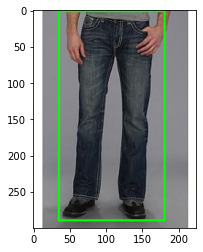

In [695]:
# visually inspect some manually chosen random items
row = subsample.iloc[12000].values
img = cv2.imread(pre_path+'fashion/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(i_w, i_h, x, y, w, h) = row[-6:]
# reconstruct the bboxes
x1 = int((x-w/2)*i_w)
y1 = int((y-h/2)*i_h)
x2 = int((x+w/2)*i_w)
y2 = int((y+h/2)*i_h)
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

### Create label/*.txt and data.yaml files

In [698]:
cats = np.array(cats)

In [704]:
%%time
# create 1 label file for each image
for i, entry in subsample.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = list(cats).index(entry.product_type)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.path.split('.')[0]
    fileroot = pre_path+'fashion/labels/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [705]:
lines = []
lines.append('path: ../datasets/fashion # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open(pre_path+'fashion/fashion.yaml', 'w')
f.writelines(lines)
f.close()

# Split into Train/Val

In [706]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(subsample, test_size=0.2)

In [707]:
if not os.path.exists(pre_path+'fashion/images'):
    os.mkdir(pre_path+'fashion/images')
if not os.path.exists(pre_path+'fashion/images/train'):
    os.mkdir(pre_path+'fashion/images/train')
if not os.path.exists(pre_path+'fashion/images/val'):
    os.mkdir(pre_path+'fashion/images/val')

if not os.path.exists(pre_path+'fashion/labels'):
    os.mkdir(pre_path+'fashion/labels')
if not os.path.exists(pre_path+'fashion/labels/train'):
    os.mkdir(pre_path+'fashion/labels/train')
if not os.path.exists(pre_path+'fashion/labels/val'):
    os.mkdir(pre_path+'fashion/labels/val')

In [708]:
for i, file in val.iterrows():
    base=file.path
    src = pre_path+'fashion/'+base
    dest = pre_path+'fashion/images/val/'+base.replace('img/', '')
    folder = pre_path+'fashion/images/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(src, dest)
    except:
        print('error on ',src)

    lbl_base = base.split('.')[0]+'.txt'
    lbl_src = pre_path+'fashion/labels/'+lbl_base
    lbl_dest = pre_path+'fashion/labels/val/'+lbl_base.replace('img/', '')
    folder = pre_path+'fashion/labels/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(lbl_src, lbl_dest)
    except:
        print('error on ',src)

error on  ../../../DeepFashion1/fashion/img/EPTM._Side-Zip_Colorblocked_Hoodie/img_00000012.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Geo-Paneled_Joggers/img_00000006.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Geo-Paneled_Joggers/img_00000021.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Victory_Sweatpants/img_00000017.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Longline_Mesh_Tee/img_00000022.jpg
error on  ../../../DeepFashion1/fashion/img/L.A._Graphic_Tee/img_00000073.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Victory_Sweatpants/img_00000013.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Tonal-Striped_Mesh_Tee/img_00000012.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Geo-Paneled_Joggers/img_00000009.jpg
error on  ../../../DeepFashion1/fashion/img/EPTM._Heathered_Mesh_Panel_Tee/img_00000028.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Victory_Sweatpants/img_00000010.jpg
error on  ../../../DeepFa

# Cleanup remaining paths and create .zip for YOLOv5 training

In [722]:
!mv ../../../DeepFashion1/fashion/img/* ../../../DeepFashion1/fashion/images/train
!rm -r ../../../DeepFashion1/fashion/img

In [723]:
!mv ../../../DeepFashion1/fashion/labels/img/* ../../../DeepFashion1/fashion/labels/train
!rm -r ../../../DeepFashion1/fashion/labels/img

In [724]:
!zip -r -q ../../../DeepFashion1/fashion.zip ../../../DeepFashion1/fashion

In [725]:
!aws s3 cp ../../../DeepFashion1/fashion.zip s3://descriptiveworld-datasets/DeepFashion1/

upload: ../../../DeepFashion1/fashion.zip to s3://descriptiveworld-datasets/DeepFashion1/fashion.zip


# Next

- Load the zip file to the yolov5/pytorch training environment in path datasets/ (to create).
- Unzip the file
- Copy or move the .yaml file to the path yolov5/data/ (expected by train.py from yolov5).  This path is available after running the setup notebook cell which clones the yolov5 repo.